In [29]:
import numpy as np
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.optim as optim

np.random.seed(5)

bit = 8
SNR_db = np.array(list(range(2 ,11 ,2)))
batch_size = 5

In [30]:
def generate_data_bit(bit, batch_size):

    input = [[0 for _ in range(pow(2, bit)) ]for _ in range(bit)]       #len = 8 [0,1]
    label = [[0 for _ in range(pow(2, bit)) ]for _ in range( 2 * bit)]   #len = 16 [0,1]

    for i in range(1<<bit):
        for j in range(bit):
            if i & ( 1<<j):
                input[ bit - j -1][i] = 1

    for i in range( 1<<bit):
        for j in range(bit):
            if input[j][i] == 1:
                label[ 2 * j ][i] = 1
                label[ 2 * j +1][i] = 0
            else:
                label[ 2 *j][i] = 0
                label[ 2 * j +1][i] = 1

    input = np.tile(np.array(input) ,batch_size) # (8, 1280)
    label = np.tile(np.array(label) ,batch_size) #(16, 1280)
    
    return input, label

def generate(M, N, batch_size):

    input, label = generate_data_bit(M, batch_size)

    ran1 = np.random.permutation(batch_size * pow(2, M))  # Suffling Dataset
    ran2 = np.random.permutation(batch_size * pow(2, M))

    symbol1 = 2 * input[:, ran1] - 1  # len = 8 [-1, 1]
    symbol2 = 2 * input[:, ran2] - 1

    SPC = math.sqrt(0.8) * symbol1 + math.sqrt(0.2) * symbol2  # Superposition Coding
    # len = 8 , [-/+0.4472136   -/+1.34164079]
    
    label1 = np.transpose(label[:, ran1].astype('float32'))  # (batch_size * 256, 16)
    label2 = np.transpose(label[:, ran2].astype('float32'))
    
    return SPC, label1, label2

def generate_input(H1_real, H1_image, SPC, N, batch_size, sigma):

    N_real, N_image = generate_channel(N, batch_size * pow(2, N), 0)

    input1_real = np.matmul(H1_real, SPC) + sigma * N_real
    input1_img = np.matmul(H1_image, SPC) + sigma * N_image

    input1 = np.transpose(np.concatenate((input1_real, input1_img), axis=0))

    return input1

def generate_channel(N, M, k):

    h1 = np.random.randn(N, M) / math.sqrt(2)
    h2 = np.random.randn(N, M) / math.sqrt(2)

    if k == 0:
        return h1, h2
    else:
        return 2 * h1, 2 * h2

In [31]:
def accuracy(out, label, bit):
  
  accuracy = 0
  for i in range(bit):

    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(tf.slice(out, [0, 2* i], [-1, 2]), 1),
                                              tf.argmax(tf.slice(label, [0, 2 * i], [-1, 2]), 1)),
                                     dtype=tf.float32))
    accuracy += acc 
  
  return accuracy / 8

In [32]:
net = nn.Sequential(
    nn.Linear(16, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 16), nn.BatchNorm1d(16), 
)

device = torch.device(f'cuda:{0}')
loss = nn.MSELoss()
net1 = net.to(device = device)
net2 = net.to(device = device)
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net1.apply(init_weights)
net2.apply(init_weights)

Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=32, bias=True)
  (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=32, bias=True)
  (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=32, out_features=16, bias=True)
  (16): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [42]:
H1_real, H1_image = generate_channel(bit, bit, 0)
H2_real, H2_image = generate_channel(bit, bit, 1)
cnt = 0
iter = 10
print('training operation')
for i in range(len(SNR_db)):

            SPC, label1_train, _ = generate(bit, bit, batch_size * train_size)
            signal_power = np.mean(pow(SPC, 2))
            sigma_user1  = math.sqrt(signal_power / (math.sqrt(bit) * pow(10, float(SNR_db[i]) / 10.0)))
            input1_train = generate_input(H1_real, H1_image, SPC, bit, batch_size * train_size, sigma_user1)

            SPC, _, label2_train = generate(bit, bit, batch_size * train_size)
            signal_power = np.mean(pow(SPC, 2))
            sigma_user2 = math.sqrt(signal_power / (math.sqrt(bit) * pow(10, float(SNR_db[i]) / 10.0)))
            input2_train = generate_input(H2_real, H2_image, SPC, bit, batch_size * train_size, sigma_user2)
            

            input1_train = torch.Tensor(input1_train)
            label1_train = torch.Tensor(label1_train)
            input1 = input1_train.cuda()
            label1= label1_train.cuda()

            input2_train = torch.Tensor(input2_train)
            label2_train = torch.Tensor(label2_train)
            input2 = input2_train.cuda()
            label2 = label2_train.cuda()

            for j in range(iter):
              optimizer1 = optim.SGD(net1.parameters(), lr = 0.01)
              optimizer1.zero_grad()
              output1 = net1(input1)
              l1 = loss(output1, label1)
              l1.backward()
              optimizer1.step()
              op1 = torch.Tensor.cpu(output1)
              out1 = op1.detach().numpy()
              acc1 = accuracy(out1, label1_train, bit)
              cnt = cnt+1

              output2 = net2(input2)
              optimizer2 = optim.SGD(net2.parameters(), lr = 0.01)
              optimizer2.zero_grad()
              l2 = loss(output2, label2)
              l2.backward()
              optimizer2.step()  
              op2 = torch.Tensor.cpu(output2)
              out2 = op2.detach().numpy()
              acc2 = accuracy(out2, label2_train, bit)
              print("iter {} User1 : {} User2 : {}".format(cnt,acc1,acc2))

training operation
iter 1 User1 : 0.4199674129486084 User2 : 0.522610068321228
iter 2 User1 : 0.6187644004821777 User2 : 0.5561283230781555
iter 3 User1 : 0.7048574686050415 User2 : 0.5734730958938599
iter 4 User1 : 0.7464274168014526 User2 : 0.5862306356430054
iter 5 User1 : 0.7725905776023865 User2 : 0.5953549146652222
iter 6 User1 : 0.7947612404823303 User2 : 0.6019922494888306
iter 7 User1 : 0.8110262155532837 User2 : 0.6070135831832886
iter 8 User1 : 0.8248875141143799 User2 : 0.611304521560669
iter 9 User1 : 0.8358606696128845 User2 : 0.6145749688148499
iter 10 User1 : 0.844341516494751 User2 : 0.6175414323806763
iter 11 User1 : 0.8565166592597961 User2 : 0.6209075450897217
iter 12 User1 : 0.862900972366333 User2 : 0.6235945224761963
iter 13 User1 : 0.8686215281486511 User2 : 0.6261451840400696
iter 14 User1 : 0.8734492063522339 User2 : 0.6281435489654541
iter 15 User1 : 0.8780032396316528 User2 : 0.6307002902030945
iter 16 User1 : 0.8807947635650635 User2 : 0.6311545372009277
it

In [43]:
Train = { "input1_train" : input1_train, "train_label1" : label1_train, "input2_train" : input2_train, "train_label2" : label2_train }
print("training data \n")
print('User1 train input : {}'.format(input1_train.shape))
print('User1 train label : {}'.format(label1_train.shape))
print('User2 train input : {}'.format(input2_train.shape))
print('User2 train label : {}'.format(label2_train.shape))

training data 

User1 train input : torch.Size([1280000, 16])
User1 train label : torch.Size([1280000, 16])
User2 train input : torch.Size([1280000, 16])
User2 train label : torch.Size([1280000, 16])


In [44]:
ERROR_user1 = np.zeros([len(SNR_db), 1])
ERROR_user2 = np.zeros([len(SNR_db), 1])

In [45]:
print('testing operation')
for i in range(len(SNR_db)):
      
      SPC_test, label1_test, label2_test = generate(bit, bit, batch_size * test_size)
      signal_power = np.mean(pow(SPC, 2))
      sigma_test = math.sqrt(signal_power / (math.sqrt(bit) * pow(10, float(SNR_db[i]) / 10.0)))
      input1_test = generate_input(H1_real, H1_image, SPC_test, bit, batch_size * test_size, sigma_test)
      input2_test = generate_input(H2_real, H2_image, SPC_test, bit, batch_size * test_size, sigma_test)
      
      input1_test = torch.Tensor(input1_test)
      label1_test = torch.Tensor(label1_test)
      input_test1 = input1_test.cuda()
      label_test1 = label1_test.cuda()
      
      testop1 = net1(input_test1)
      opt1 = torch.Tensor.cpu(testop1)
      out1 = opt1.detach().numpy()
      ac1 = accuracy(out1, label1_test, bit)
      ERROR_user1[i, k] = 1 - ac1

      input2_test = torch.Tensor(input2_test)
      label2_test = torch.Tensor(label2_test)
      input_test2 = input2_test.cuda()
      label_test2 = label2_test.cuda()
      
      testop2 = net2(input_test2)
      opt2 = torch.Tensor.cpu(testop2)
      out2 = opt2.detach().numpy()
      ac2 = accuracy(out2, label2_test, bit)
      ERROR_user2[i, k] = 1 - ac2

testing operation


In [46]:
Test = { "input1_test" : input1_test, "input2_test" : input2_test, "test_label1" : label1_test, "test_label2" : label2_test }
print("testing data")

print('User1 test input : {}'.format(input1_test.shape))
print('User1 test label : {}'.format(label1_test.shape))
print('User2 test input : {}'.format(input2_test.shape))
print('User2 test label : {}'.format(label2_test.shape))

testing data
User1 test input : torch.Size([128000, 16])
User1 test label : torch.Size([128000, 16])
User2 test input : torch.Size([128000, 16])
User2 test label : torch.Size([128000, 16])


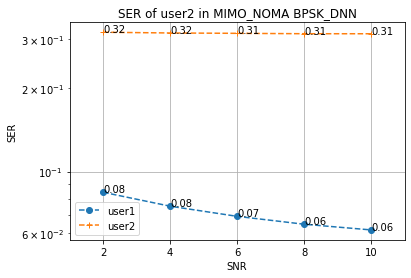

SNR : [ 2  4  6  8 10]
bit error for user 1 at testing : [0.08433008 0.07513869 0.06908393 0.06471288 0.06173432]
bit error for user 2 at testing : [0.31761718 0.31570899 0.31475484 0.31375581 0.31367576]


In [47]:
error1 = np.mean(ERROR_user1, axis=1)
error2 = np.mean((ERROR_user2), axis=1)
# print(H1_real)
plt.figure()
plt.semilogy(SNR_db, error1, ls='--', marker='o', label='user1')
plt.semilogy(SNR_db, error2, ls='--', marker='+', label='user2')
for i in range(5):
  label1 = "{:.2f}".format(error1[i])
  label2 = "{:.2f}".format(error2[i])
  plt.annotate(label1,(SNR_db[i],ERROR_user1[i]))
  plt.annotate(label2,(SNR_db[i],ERROR_user2[i]))
plt.grid()
plt.legend()
plt.xlim(pow(10, 0), pow(11, 1))
plt.xlabel('SNR')
plt.ylabel('SER')
plt.title('SER of user2 in MIMO_NOMA BPSK_DNN')
plt.savefig('SER_MIMO_NOMA_DNN_BPSK')
plt.show()
print("SNR : {}".format(SNR_db))
print("bit error for user 1 at testing : {}".format(error1))
print("bit error for user 2 at testing : {}".format(error2))